In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from math import sqrt
from joblib import dump, load

In [227]:
# Instancia o dataframe

df_airbnb = pd.read_csv('airbnb.csv', index_col='id', engine='python', sep =',', encoding="utf-8")

In [228]:
# Calcula métricas de desempenho do regressor.

def get_metrics(y_test, y_pred):  

    rmse = round(sqrt(mean_squared_error(y_test, y_pred)),4)
    r2 = round(r2_score(y_test, y_pred),4)

    return rmse, r2

In [229]:
# Define semente aleatória

random_state=1223614

In [230]:
# Vamos dividir da seguinte forma: 90% para treino e 10% para teste. 
# Os registros deverão ser embaralhados.

X = df_airbnb.drop(columns=['price'])
y = df_airbnb['price']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.1, random_state=random_state)

print("Quantidade de registros de X_train: " + str(X_train.shape[0]))
print("Quantidade de registros de y_train: " + str(y_train.shape[0]))
print("Quantidade de registros de X_test: " + str(X_test.shape[0]))
print("Quantidade de registros de y_test: " + str(y_test.shape[0]))

Quantidade de registros de X_train: 6300
Quantidade de registros de y_train: 6300
Quantidade de registros de X_test: 700
Quantidade de registros de y_test: 700


In [231]:
# Carrega o modelo treinado salvo previamente
regr = load('regressor.joblib')

In [232]:
# Avalia a performance do modelo treinado, usando a massa reservada para testes.
# E obtém as métricas de desempenho - o quanto nosso modelo acertou?
# RMSE (Raiz do erro médio quadrático - Quanto mais próximo a 0.0000, melhor)
# R² (Coeficiente de determinação - Quanto mais  próximo a 1.0000, melhor)

y_pred = regr.predict(X_test)
rmse, r2 = get_metrics(y_test, y_pred)
comparacao = []
comparacao.append(('Regressor Otimizado', rmse, r2))
print('RMSE: ',rmse)
print('R²: ',r2)

RMSE:  93.1471
R²:  0.4603


In [233]:
# Comparando os resultados com o LinearRegressor, o nosso algoritmo de base.

linear_regr = LinearRegression()
linear_regr.fit(X_train, y_train)
y_pred_baseline = linear_regr.predict(X_test)
rmse, r2 = get_metrics(y_test, y_pred_baseline)
comparacao.append(('Regressor Básico', rmse, r2))
print('RMSE: ',rmse)
print('R²: ',r2)

RMSE:  102.0199
R²:  0.3525


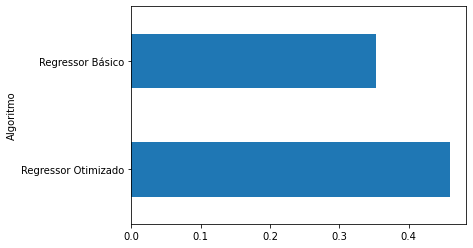

In [234]:
df_comparacao = pd.DataFrame(data=comparacao, columns=['Algoritmo', 'RMSE', 'R2'])
df_comparacao.set_index('Algoritmo', inplace=True)
df_comparacao.sort_values('R2', ascending=False, inplace=True)
df_comparacao['R2'].plot.barh()

In [235]:
# Exemplo de visualização de dados
results = pd.DataFrame(np.array(y_test).flatten(),columns=['Realizado'])
results['Previsto'] = np.array(y_pred)
results['Id'] = X_test.index
results = results[['Id', 'Realizado', 'Previsto']]
results

,Id,Realizado,Previsto
0,10711296,101.0,154.230446
1,13257826,252.0,409.395275
2,5172574,491.0,352.183161
3,9205886,231.0,227.540391
4,846716,243.0,146.322296
...,...,...,...
695,29512201,382.0,265.703430
696,849887,151.0,184.219114
697,30002641,92.0,160.098195
698,32544922,202.0,153.158725


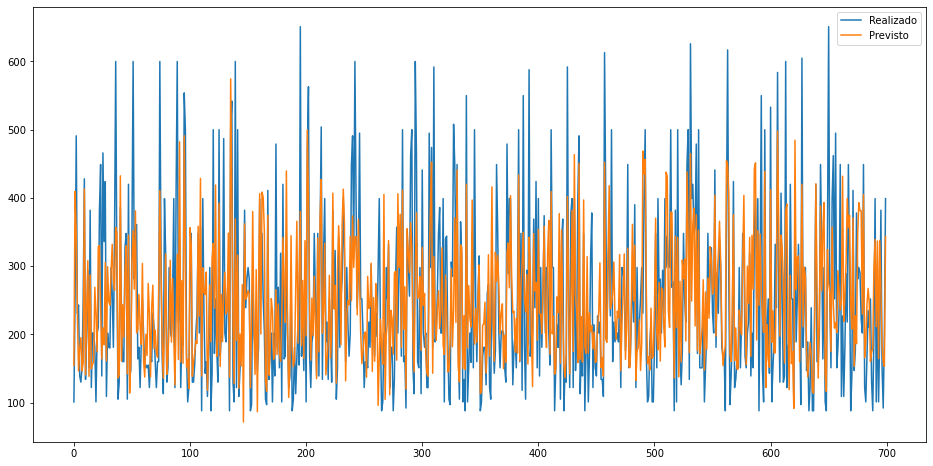

In [236]:
results[['Realizado', 'Previsto']][:].plot(kind='line', figsize=(16,8))

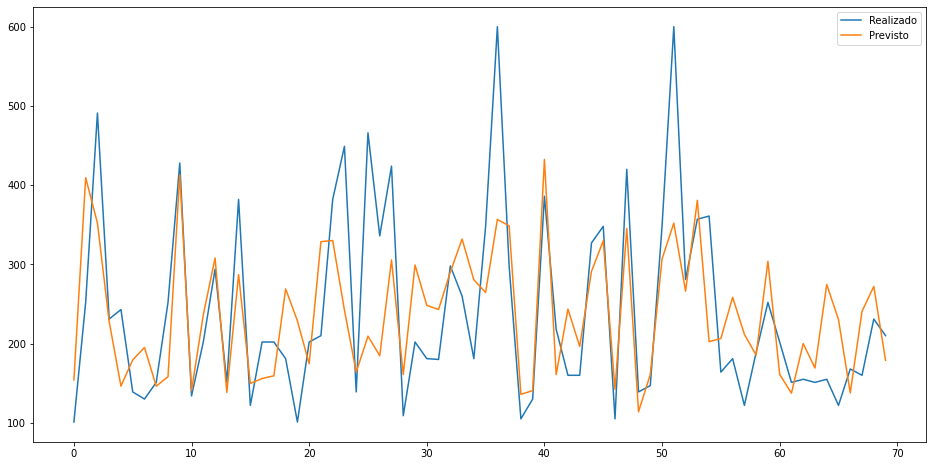

In [237]:
results[['Realizado', 'Previsto']][0:70].plot(kind='line', figsize=(16,8))

In [238]:
results['Diferença'] = results['Realizado'] - results['Previsto']
results.set_index('Id', inplace=True)
results

,Realizado,Previsto,Diferença
Id,,,
10711296,101.0,154.230446,-53.230446
13257826,252.0,409.395275,-157.395275
5172574,491.0,352.183161,138.816839
9205886,231.0,227.540391,3.459609
846716,243.0,146.322296,96.677704
...,...,...,...
29512201,382.0,265.703430,116.296570
849887,151.0,184.219114,-33.219114
30002641,92.0,160.098195,-68.098195


In [239]:
anuncios_baratos = results[['Diferença']]
anuncios_baratos.query('Diferença < 0', inplace = True)

In [240]:
anuncios_baratos

,Diferença
Id,
10711296,-53.230446
13257826,-157.395275
14267593,-40.370298
26275626,-65.117737
51703,-6.656097
...,...
12846452,-93.759340
22486276,-63.368090
16552375,-135.427251


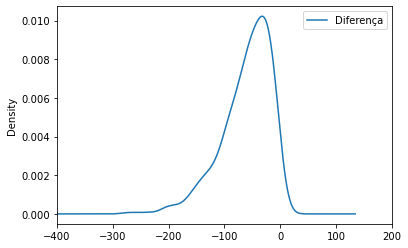

In [241]:
anuncios_baratos.plot.density(xlim=(-400, 200))

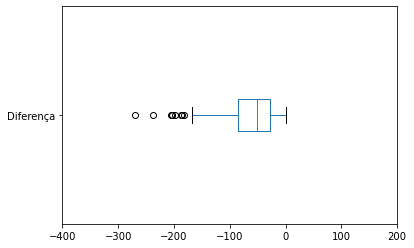

In [242]:
anuncios_baratos.plot.box(xlim=(-400, 200), vert=False)

In [243]:
anuncios_baratos.quantile([0, 0.25, 0.5, 0.75, 1])['Diferença'].tolist()

[-269.0999852086452,
 -85.21082794286977,
 -51.03011308384524,
 -27.34703790000328,
 -0.0540177791913834]

In [244]:
results.quantile([0, 0.25, 0.5, 0.75, 1])['Diferença'].tolist()

[-269.0999852086452,
 -60.70556600072263,
 -18.065864820625265,
 40.920559543745966,
 376.1932704815571]

In [245]:
diferenca_ideal = round(float(anuncios_baratos['Diferença'].median()),2)
print("Diferença ideal: R$ " + str(diferenca_ideal))

Diferença ideal: R$ -51.03


In [246]:
# Criação do ranking dos anúncios e ordenamento do dataframe
# Os anúncios com valor mais próximo da diferença ideal entre os valores previstos e realizados terão um melhor score.

distancia_da_diferenca_ideal = abs(diferenca_ideal - results['Diferença'])
distancia_min_da_diferenca_ideal = 0
distancia_max_do_valor_mais_barato = abs(diferenca_ideal - results.quantile([0])['Diferença'].tolist()[0])
distancia_max_do_valor_mais_caro = abs(diferenca_ideal - results.quantile([1])['Diferença'].tolist()[0])
distancia_max_da_diferenca_ideal = max(distancia_max_do_valor_mais_barato, distancia_max_do_valor_mais_caro)
distancia_invertida = distancia_max_da_diferenca_ideal - distancia_da_diferenca_ideal

results['Ranking'] = distancia_invertida / distancia_max_da_diferenca_ideal
results.sort_values('Ranking', ascending=False, inplace=True)
results[['Realizado', 'Previsto', 'Diferença', 'Ranking']]

,Realizado,Previsto,Diferença,Ranking
Id,,,,
28192721,181.0,232.015571,-51.015571,0.999966
5188261,151.0,202.044655,-51.044655,0.999966
37799557,88.0,139.010351,-51.010351,0.999954
14816747,176.0,227.251853,-51.251853,0.999481
22784065,113.0,163.702441,-50.702441,0.999233
...,...,...,...,...
10674363,600.0,317.477987,282.522013,0.219256
11633008,550.0,261.433483,288.566517,0.205108
31398622,600.0,294.067827,305.932173,0.164460


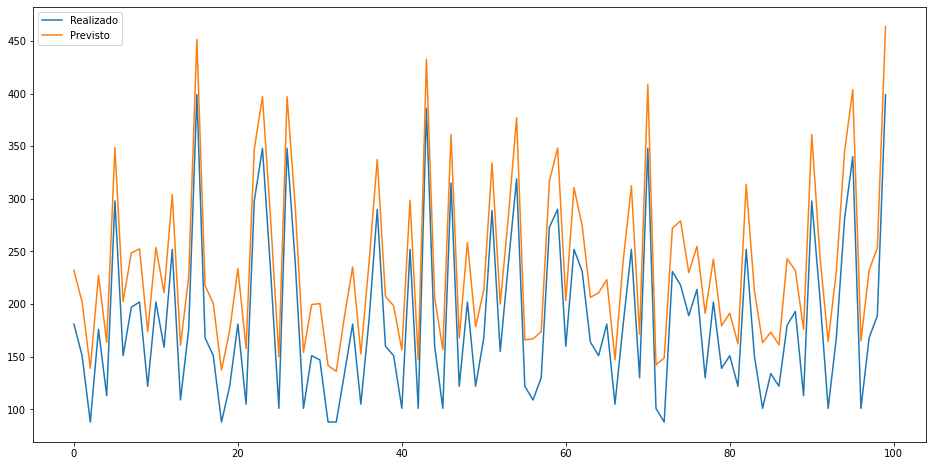

In [247]:
results.reset_index()[['Realizado', 'Previsto']][0:100].plot(kind='line', figsize=(16,8))

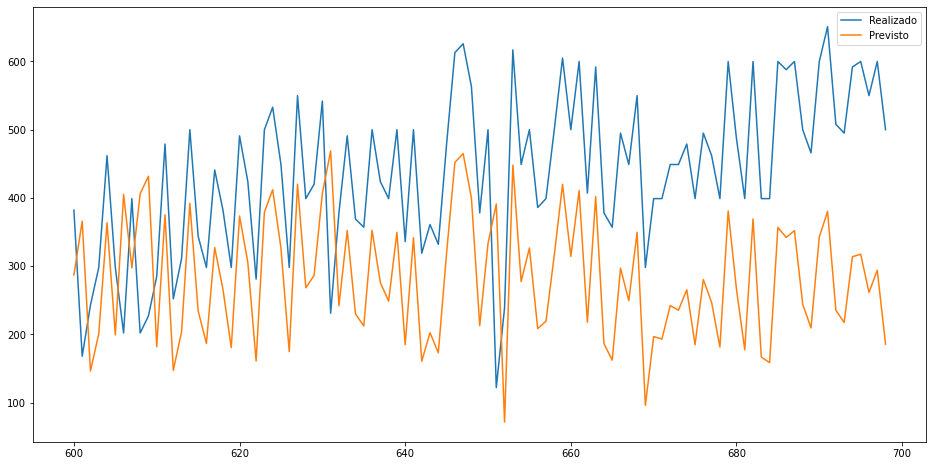

In [255]:
results.reset_index()[['Realizado', 'Previsto']][-100:-1].plot(kind='line', figsize=(16,8))

In [249]:
df_listings = pd.read_csv('listings.csv', index_col='id', engine='python', sep =',', encoding="utf-8")

In [253]:
id_do_anuncio = int(input())
anuncio = df_listings[df_listings.index == id_do_anuncio]
print(df_listings.index.name + ': ' + str(id_do_anuncio) + '\n')
for coluna in anuncio:
    print(coluna + ': ' + str(df_listings.loc[id_do_anuncio, coluna]) + '\n')

id: 5188261

listing_url: https://www.airbnb.com/rooms/5188261

scrape_id: 20191122092441

last_scraped: 2019-11-22

name: Brand new studio in Ipanema with good wi-fi!

summary: MINIMUM STAY: 3-DAY CARNIVAL: 5 DAY MINIMUM Agreeable & well equipped studio for 3, recently renewed in a great style! The location is super: 3 blocks from the beach & 150 meters from the metro station. The street is calm and full of trees! The building is strictly familiar

space: The studio is very comfortable and everything is brand new! It is equipped with:  . DOUBLE BED  . 39" FLAT CABLE TV   . WI-FI  . AIR CONDITIONING  . NOISE PROTECTED WINDOW . MODERN KITCHEN  . 2 RING STOVE . HOOD FAT  . REFRIGERATOR  . MICROWAVE  . CUTLERY & UTENSILS  . TOASTER  . COFFEE MACHINE  . TABLE FOR 3  . SPACIOUS BATHROOM  . CLOSET  . APARTMENT'S SIZE: 30m² . PRIVILEGED LOCATION  . ENTERTAINMENT AND SERVICES IN THE AREA  . CLOSE TO RESTAURANTS, BARS AND SUPERMARKETS  . 150M FROM BUSES AND TAXIS STOPS  Everything was planned w